### 0 - Étapes préliminaires
#### 0.a - Importation des librairies

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from fcts.general import * 
from fcts.methode_fait_maison import *
from fcts.KNN_sel_var import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier

#### 0.b - Téléchargement du jeu de données 

In [2]:
data = pd.read_csv("stars_train.csv")

#On sépare les covariables et variable à prédire 
X = data[data.columns[0:-1]]
y = data[["label"]]

#On divise nos jeux de données en un set d'entraînement et test
X_tr, X_te, y_tr, y_te = train_test_split(X,y, test_size=0.33, random_state=42)

### 1-  Étude de l'importance des variables 

Nous allons examiner tout d'abord l'importance des variables à partir d'une forêt aléatoire. 

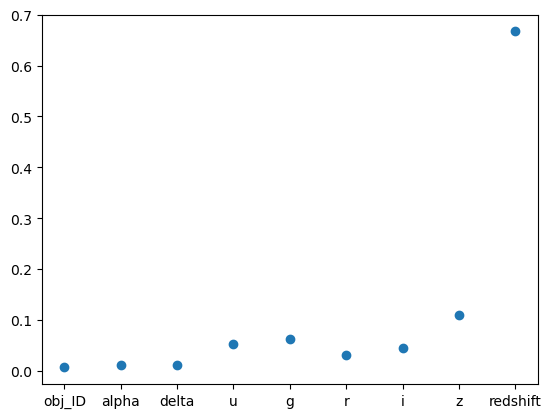

In [24]:
from sklearn.ensemble import RandomForestClassifier

mod = RandomForestClassifier(bootstrap=True)
mod.fit(X_tr,y_tr.to_numpy().ravel())

plt.scatter(X_tr.columns, mod.feature_importances_)

On remarque que l'on peut regrouper nos variables en fonction de categories d'importance. 

On remarque que la variable redshift a une très forte importance au niveau dans ce problème de classification.  
En effet, en revenant au graphique dans l'analyse exploratoire des variables, on avait remarqué que la variable redshift permet de définir une claire frontière entre les trois classes. On peut envisager de calculer les seuils qui permettent de maximiser le f1_score dans la tâche de la classification multiclasse. 

On constate un groupe de les variables: u, g, r, i et z avec une importance inférieure à 0.1 et assez similaire. 

Puis dernièrement, un groupe de variables a importance nettement plus faible que le reste: obj_ID, alpha, delta.

### 2- Méthode fait-maison

<Axes: xlabel='alpha', ylabel='redshift'>

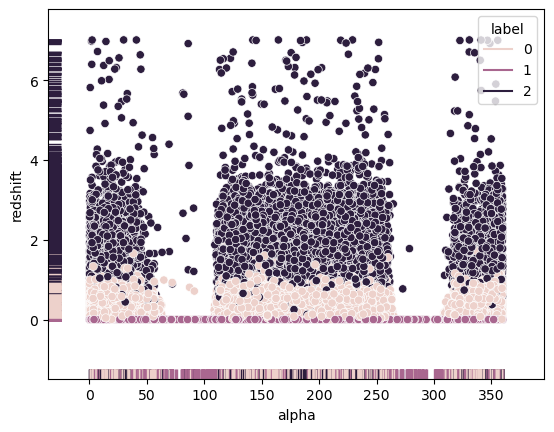

In [25]:
sns.scatterplot(data, x="alpha", y="redshift", hue = 'label')
sns.rugplot(data, x="alpha", y="redshift", hue = 'label')

On remarque que les classes sont réparties de la façon suivante: 1 < 0 < 2. 

C'est dans cette logique que nous avons construit la fonction methode_fait_maison. Cette fonction calcule le seuil maximisant le f1_score (par cross-validation) entre deux classes à partir des valeurs de "redshift". Nous avons donc effectué la classification en deux temps. 

1- Trouver le seuil qui classifie au mieux: 1 et 3 (nouvelle étiquette crée à partir des individus 0 et 2) 

2- Trouver le seuil qui sépare au mieux 3 (nouvelle étiquette crée à partir des individus 1 et 0) et 2

#### 2.a - Calcul des seuils 

/Users/laurafuentesvicente/opt/anaconda3/envs/datachallenge/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/laurafuentesvicente/opt/anaconda3/envs/datachallenge/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


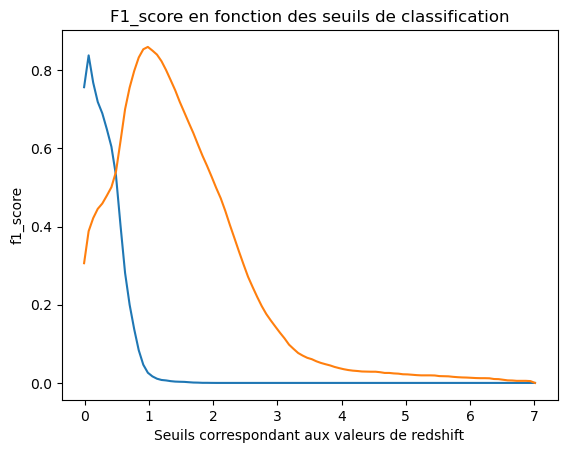

In [26]:
#Calcul des seuils 
seuil_0,seuil_2 = choix_seuils(X_tr,y_tr,5,100, "redshift")

#Calcul de la prédiction issue de cette classification en 1-D: 
methode_fait_maison = Label_Encode(y_tr,pd.DataFrame(predict(seuil_0,seuil_2, X_te, "redshift")))

#### 2.b - Évaluation des résultats

In [27]:
c_m = confusion_matrix(y_te.to_numpy(), methode_fait_maison) / confusion_matrix(y_te.to_numpy(), methode_fait_maison).sum()
print("Matrice confusion: ")
print(c_m)
print("")
taux_mal_classes = c_m[0,1:2] + c_m[1,0] + c_m[1,2] + c_m[2,0:1] + c_m[2,0:1]
print("taux_mal_classes: ", taux_mal_classes)
print("")
print("f1_score: ", f1_score(y_te.to_numpy(), methode_fait_maison,average="weighted"))

Matrice confusion: 
[[5.67099316e-01 3.58674238e-02 1.06617221e-02]
 [0.00000000e+00 2.10105458e-01 0.00000000e+00]
 [3.52879824e-02 5.79441418e-05 1.40920153e-01]]

taux_mal_classes:  [0.10644339]

f1_score:  0.9174295068999387


On constate que: 

- Les résultats avec une unique variable sont déjà assez bons. 

- Notre modèle predit correctement le label 1.En effet, notre modèle ne choisi pas le label 0 ou 2 quand il s'agit d'un 1.  
- Confusions: 
    - la plus importante: Pred: 0 alors que True: 2.

Ceci pourrait être du a une sur-estimation de la classe 1.   

### 3- Choix des variables sur le modèle KNN 

Dans le graphique de l'importance des variables, on avait remarqué que les variables (u, g, r, i et z) avaient de façon assez uniforme, la même importance. Or, on a vu en cours, que cette mesure d'importance pouvait porter a malinterpretation au niveau de variables portant le même type d'information. En effet, des variables portant la même information ont souvent une importance unforme et basse. Alors que l'information apportée par ce groupe de variables peut s'avérée clée au niveau de la prédiction. 

L'implementation de nouvelles variables dans la méthode fait-maison devient rapidement ardue. Ce faisant, nous avons décidé par la suite de nous concentrer sur le prédicteur KNN, et d'effectuer un choix de variables. 

0.9612645535954172


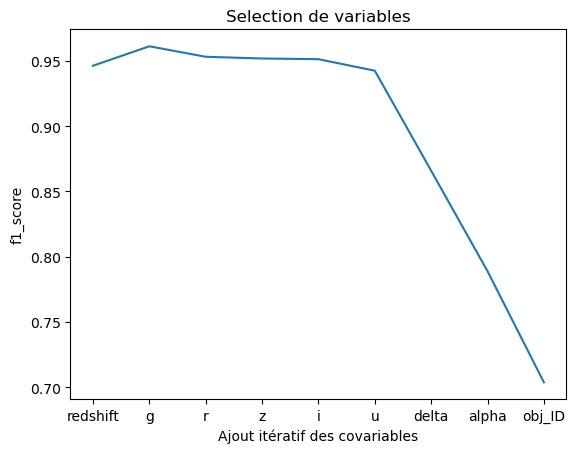

In [28]:
selection_var = main(X_tr, y_tr, X_te, y_te)
knn_pred = train(X_tr,y_tr,X_te, selection_var)
print(f1_score(y_te, knn_pred, average="weighted"))

### 4- Choix des hyperparamètres

In [15]:
from sklearn.model_selection import GridSearchCV

param={'n_neighbors':[4,5,6,7,8,9, 10, 15, 20],"weights":['uniform', 'distance'],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 'p': [1,2]}

grid_search = GridSearchCV(estimator=KNeighborsClassifier(),param_grid=param,cv=5)
grid_search.fit(X_tr[["redshift","g"]], y_tr.to_numpy().ravel())

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Hyperparameters:  {'algorithm': 'auto', 'n_neighbors': 6, 'p': 2, 'weights': 'uniform'}
Best Score:  0.9595285625985234


Les hyperparamètres selectionnés sont ainsi les hyperparamètres par défaut sauf pour n_neighbors. 

### 5 - Mélange de prédicteurs 

On peut essayer de mélanger nos deux prédicteurs dans la suite pour voir s'il y a une amélioration des performances. On effectuera ce mélange en associant aux index où les deux prédictions diffèrent, une des deux prédictions tirées aléatoirement sur une Bernoulli. 
Pour cela, nous allons créer deux fonctions: 
- Une premiere, qui calcule par cross-validation la probabilité p maximisant le score f1_score 
- Une deuxième qui effectue le mélange des deux prédicteurs pour la probabilité choisie. 

In [16]:
%%capture --no-display
#On entraîne le modèle à mélanger avec la méthode fait maison: 
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_tr[selection_var],y_tr.to_numpy().ravel())

# On calcule la probabilité p par cross-validation: 
prob = melange(5,X_tr,y_tr, "redshift", [seuil_0,seuil_2], knn, selection_var)

NameError: name 'selection_var' is not defined

In [31]:
prob

1.0

On constate que le mieux c'est de ne pas mélanger nos prédicteurs. Ainsi, notre prédicteur choisi est le prédicteur issu du modèle KNN à deux variables, "redshift" et "g". 